In [6]:
!pip install missingno
import os
import pandas as pd
import numpy as np

Data Cleaning Functions:
    1. Normalize date to nearest 15T min increment
    2. Fill empty rows with DataTimeStamps where data is missing
    3. Data quality check
    3. Visualize missing data 
    4. Decide on data imputation

In [59]:
# Function to normalize time to the nearest 15-minute increment
def round_time_to_15min(dt):
    dt += timedelta(minutes=7.5)
    dt -= timedelta(minutes=dt.minute % 15, seconds=dt.second)
    return dt

In [7]:
# Function to fill gaps in data with empty rows

def fill_gaps(df):
    year = df['DateTimeStamp'].dt.year.iloc[0]          # Get the year from the DateTimeStamp column
    start_time = pd.Timestamp(year, 1, 1)              # Set the start time to the beginning of the year
    end_time = pd.Timestamp(year, 12, 31, 23, 59, 59)     # Set the end time to the end of the year
    expected_times = pd.date_range(start=start_time, end=end_time, freq='15T')  # Generate expected times within the year
    
    # Find missing times within the year
    missing_times_within_year = expected_times[~expected_times.isin(df['DateTimeStamp'])]
    
    # Create missing data DataFrame
    missing_data = pd.DataFrame({
        'DateTimeStamp': missing_times_within_year,
        'Occupancy': np.nan,
        'Volume': np.nan,
        'Speed': np.nan
    })
    
    filled_df = pd.concat([df, missing_data]).sort_values(by='DateTimeStamp')    # Concatenate missing_data with original DataFrame
    
    return filled_df

In [ ]:
# Main script to clean the sensor data

input_directory = 'C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/2. transformed sensor files/2018'
output_directory = 'C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018'

# Read and process each CSV file
for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        input_filepath = os.path.join(input_directory, filename)
        df = pd.read_csv(input_filepath, parse_dates=['DateTimeStamp'])

        # Normalize time to the nearest 15-minute increment
        df['DateTimeStamp'] = df['DateTimeStamp'].apply(round_time_to_15min)

        # Fill gaps in data with empty rows
        df = fill_gaps(df)

        # Save the processed data to a new CSV file
        output_filename = os.path.splitext(filename)[0] + '_processed.csv'
        output_filepath = os.path.join(output_directory, output_filename)
        df.to_csv(output_filepath, index=False)

        print(f"Processed file: {output_filepath}")

In [5]:
# Data Quality Check
# Check if the row count of each CSV file is equal to 35040 - quick check

def check_csv_row_count(directory):
    file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.csv')]
    
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        row_count = len(df)
        
        # Check if the row count is not equal to 35040
        if row_count != 35040:
            print(f"{file_path}: {row_count} rows")
          

# Set directory path
check_csv_row_count('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018')

In [ ]:
# Data Quality Check
# Check for duplicates in column 1 (DateTimeStamp)

def check_duplicates_in_column1(directory):
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    
    for file_name in csv_files:
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)
        
        # Calculate row count
        row_count = len(df)
        
        # Check for duplicates in the first column
        duplicates = df[df.duplicated(subset=[df.columns[0]], keep=False)]
        
        if not duplicates.empty:
            print(f"Duplicates found in {file_name} (Total Rows: {row_count}):")
            print(duplicates)
        else:
            print(f"No duplicates found in {file_name} (Total Rows: {row_count})")

# Set directory path
check_duplicates_in_column1('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018')


In [ ]:
# Data Quality Check
# Aggregate duplicates by taking the mean of the values and rounding to the nearest integer for Occupancy and Volume and to 2 decimal places for Speed

def check_and_handle_duplicates(directory):
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    for file_name in csv_files:
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)
        duplicate_timestamps = df[df.duplicated(subset=['DateTimeStamp'], keep=False)]
        
        # Handle duplicates by aggregating values
        if not duplicate_timestamps.empty:
            # Aggregate duplicates by taking the mean of numeric columns
            aggregated_df = duplicate_timestamps.groupby('DateTimeStamp').mean().reset_index()
            # Round 'Occupancy' and 'Volume' columns to nearest integer
            aggregated_df['Occupancy'] = aggregated_df['Occupancy'].round().astype(int)
            aggregated_df['Volume'] = aggregated_df['Volume'].round().astype(int)
            df.drop_duplicates(subset=['DateTimeStamp'], keep=False, inplace=True)
            df = pd.concat([df, aggregated_df], ignore_index=True)
            df.to_csv(file_path, index=False)

            print(f"Duplicates handled in {file_name}")
        else:
            print(f"No duplicates found in {file_name}")

# Set directory path
check_and_handle_duplicates('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018')

In [102]:
df = pd.read_csv('../Chloe - Reduced Detector Data - all_combined.csv', header=None)
result = df[df[1].str.contains("I-15 NB", na=False)][0].tolist()

result = [value.replace('_', '.') for value in result]

total_elements = len(result)
print(f"Total elements: {total_elements}")

directory = 'C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018'

speed_data = pd.DataFrame()

# Iterate over each name in the result list
for name in result:
    # Add '_processed' suffix to the name
    processed_name = f"{name}_processed"
    
    if os.path.exists(os.path.join(directory, f'{processed_name}.csv')):
        # Read the CSV file into a DataFrame
        file_df = pd.read_csv(os.path.join(directory, f'{processed_name}.csv'))
        
        # Extract the 'Speed' column
        speed_column = file_df['Speed']
        
        # Extract the file name without the '_processed' part
        file_name = processed_name.replace('_processed', '')
        
        # Rename the column with the file name
        speed_column = speed_column.rename(file_name)
        
        # Convert the speed column to a DataFrame with a single column
        speed_column = pd.DataFrame(speed_column)
        
        # Concatenate the speed column to the speed_data DataFrame
        speed_data = pd.concat([speed_data, speed_column], axis=1)
    else:
        print(f"File not found: {processed_name}.csv")

# Print the concatenated DataFrame
print(speed_data)

Total elements: 180
File not found: 127.1.531_processed.csv
File not found: 160.1.241_processed.csv
File not found: 167.1.531_processed.csv
File not found: 23.1.8_processed.csv
File not found: 23.2.8_processed.csv
File not found: 30.2.8_processed.csv
File not found: 39.1.8_processed.csv
File not found: 437.1.101_processed.csv
File not found: 524.3.8_processed.csv
File not found: 53.2.15_processed.csv
File not found: 536.1.100_processed.csv
File not found: 538.1.101_processed.csv
File not found: 544.1.99_processed.csv
File not found: 545.1.99_processed.csv
File not found: 698.1.539_processed.csv
File not found: 403.3.448_processed.csv
File not found: 160.1.241 _processed.csv
File not found: 161.2.241_processed.csv
File not found: 34.2.90_processed.csv
File not found: 356.3.313_processed.csv
File not found: 437.1.328_processed.csv
File not found: 437.2.327_processed.csv
File not found: 441.2.337_processed.csv
File not found: 442.3.339_processed.csv
File not found: 446.2.78_processed.csv


In [142]:
dt = pd.read_csv('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018/72.2.28_processed.csv', parse_dates=['DateTimeStamp'])
dt=dt.iloc[:, 0]
dt


0       2018-01-01 00:00:00
1       2018-01-01 00:15:00
2       2018-01-01 00:30:00
3       2018-01-01 00:45:00
4       2018-01-01 01:00:00
                ...        
35035   2018-12-31 23:30:00
35036   2018-12-31 23:45:00
35037   2018-11-04 01:15:00
35038   2018-11-04 01:30:00
35039   2018-11-04 01:45:00
Name: DateTimeStamp, Length: 35040, dtype: datetime64[ns]

In [144]:
speed_data.reset_index(drop=True, inplace=True)
speed_data

,101.1.35,125.2.49,126.1.49,126.2.80,138.2.55,141.2.55,154.2.240,167.2.210,38.1.91,398.3.411,...,99.1.35,522.1.17,522.2.15,523.1.12,523.2.84,525.1.93,525.2.142,525.3.145,526.1.144,526.2.79
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,55.50,49.0,30.0,NaN,0.0,0.0,64.00,0.0,62.500000,...,66.6,44.000000,56.00,59.500000,NaN,0.0,0.0,82.00,0.00,0.00
2,0.0,55.00,50.0,30.0,NaN,0.0,0.0,62.50,0.0,53.500000,...,68.2,28.333333,55.00,59.000000,NaN,0.0,0.0,81.50,0.00,0.00
3,0.0,54.00,50.0,30.0,NaN,0.0,0.0,61.50,0.0,51.500000,...,67.6,11.333333,55.00,59.000000,NaN,0.0,0.0,84.50,0.00,0.00
4,0.0,54.00,50.0,30.0,NaN,0.0,0.0,63.00,0.0,59.500000,...,67.8,26.500000,55.00,58.000000,NaN,0.0,0.0,84.50,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,NaN,61.00,NaN,NaN,NaN,0.0,0.0,63.00,NaN,61.333333,...,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,80.50,70.50,73.00
35036,NaN,61.50,NaN,NaN,NaN,0.0,0.0,64.00,NaN,61.000000,...,NaN,NaN,NaN,37.666667,NaN,NaN,NaN,80.00,70.00,72.00
35037,NaN,57.00,54.0,NaN,NaN,0.0,0.0,63.25,0.0,41.666667,...,NaN,61.833333,60.50,64.833333,NaN,NaN,NaN,76.00,69.50,73.00
35038,NaN,57.50,54.0,NaN,NaN,0.0,0.0,63.75,0.0,38.833333,...,NaN,64.166667,61.75,63.666667,NaN,NaN,NaN,79.25,70.75,73.25


In [145]:
speed_data_2=speed_data
speed_data_2 = pd.concat([dt, speed_data_2], axis=1)
#speed_data_2 = speed_data_2.iloc[:, 1:]

In [146]:
speed_data_2

,DateTimeStamp,101.1.35,125.2.49,126.1.49,126.2.80,138.2.55,141.2.55,154.2.240,167.2.210,38.1.91,...,99.1.35,522.1.17,522.2.15,523.1.12,523.2.84,525.1.93,525.2.142,525.3.145,526.1.144,526.2.79
0,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:15:00,0.0,55.50,49.0,30.0,NaN,0.0,0.0,64.00,0.0,...,66.6,44.000000,56.00,59.500000,NaN,0.0,0.0,82.00,0.00,0.00
2,2018-01-01 00:30:00,0.0,55.00,50.0,30.0,NaN,0.0,0.0,62.50,0.0,...,68.2,28.333333,55.00,59.000000,NaN,0.0,0.0,81.50,0.00,0.00
3,2018-01-01 00:45:00,0.0,54.00,50.0,30.0,NaN,0.0,0.0,61.50,0.0,...,67.6,11.333333,55.00,59.000000,NaN,0.0,0.0,84.50,0.00,0.00
4,2018-01-01 01:00:00,0.0,54.00,50.0,30.0,NaN,0.0,0.0,63.00,0.0,...,67.8,26.500000,55.00,58.000000,NaN,0.0,0.0,84.50,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 23:30:00,NaN,61.00,NaN,NaN,NaN,0.0,0.0,63.00,NaN,...,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,80.50,70.50,73.00
35036,2018-12-31 23:45:00,NaN,61.50,NaN,NaN,NaN,0.0,0.0,64.00,NaN,...,NaN,NaN,NaN,37.666667,NaN,NaN,NaN,80.00,70.00,72.00
35037,2018-11-04 01:15:00,NaN,57.00,54.0,NaN,NaN,0.0,0.0,63.25,0.0,...,NaN,61.833333,60.50,64.833333,NaN,NaN,NaN,76.00,69.50,73.00
35038,2018-11-04 01:30:00,NaN,57.50,54.0,NaN,NaN,0.0,0.0,63.75,0.0,...,NaN,64.166667,61.75,63.666667,NaN,NaN,NaN,79.25,70.75,73.25


<Axes: >

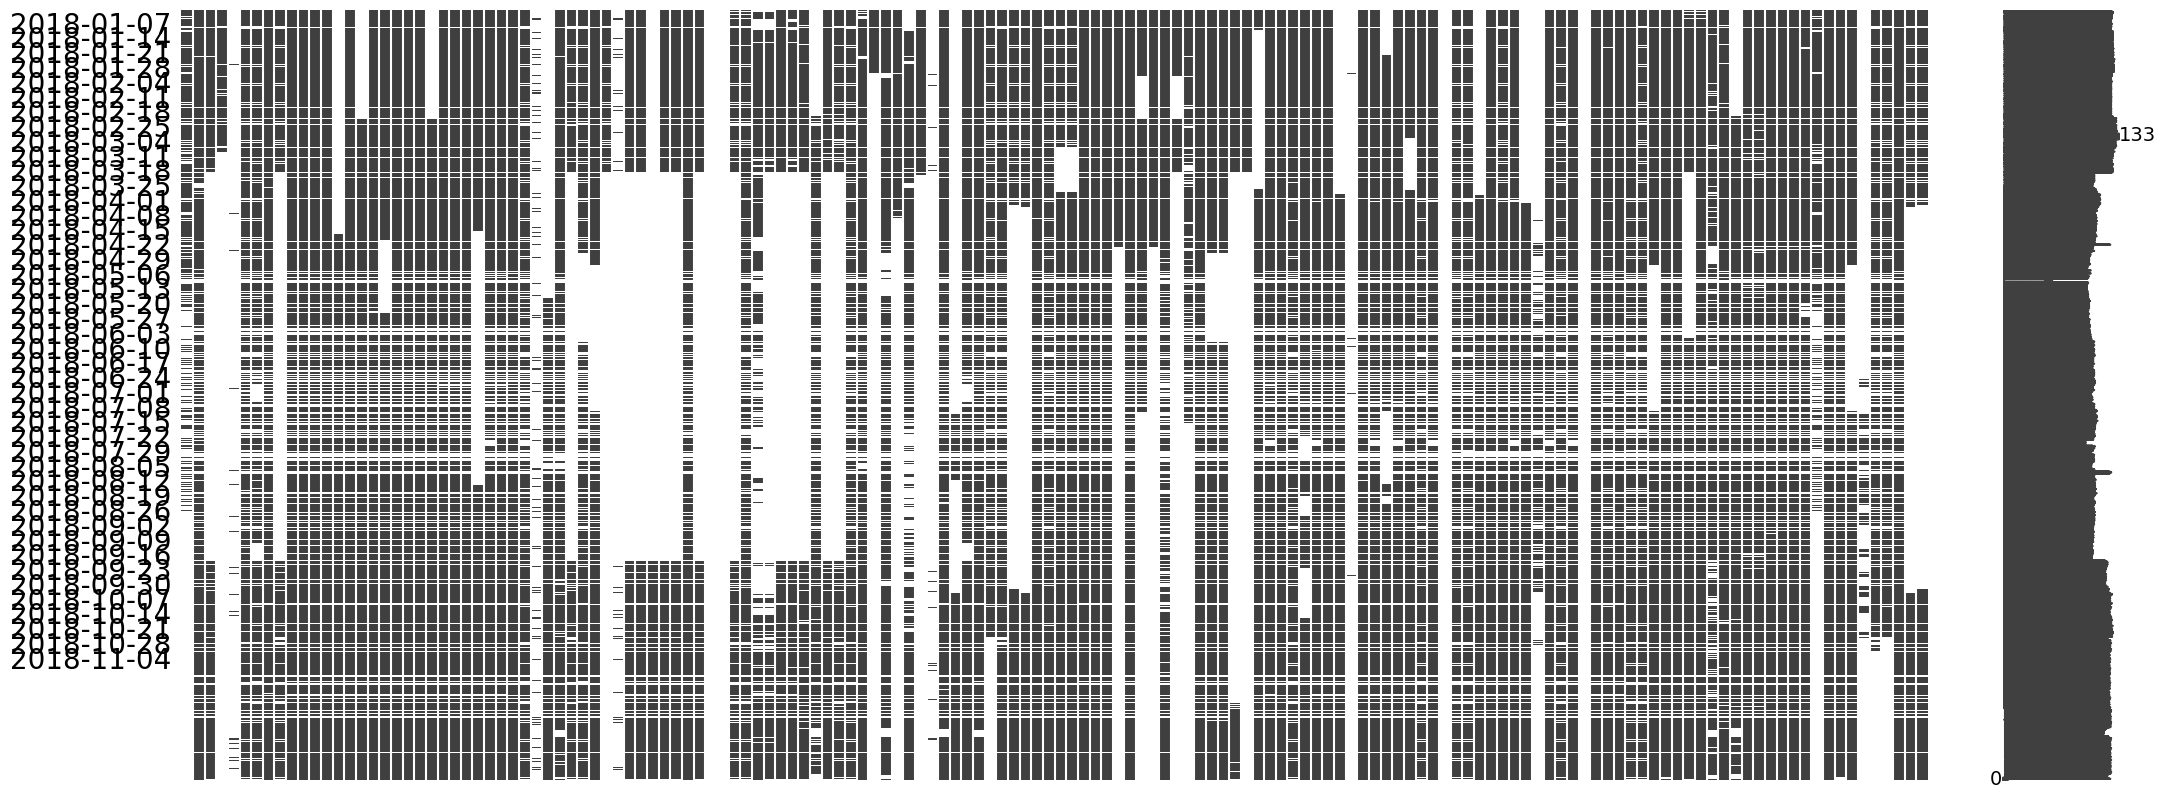

In [153]:
#speed_data_2['DateTimeStamp'] = pd.to_datetime(speed_data_2['DateTimeStamp'])

#speed_data_2.set_index('DateTimeStamp', inplace=True)

speed_data_2.index = pd.to_datetime(speed_data_2.index)
msno.matrix(speed_data_2, freq='W')

<Axes: >

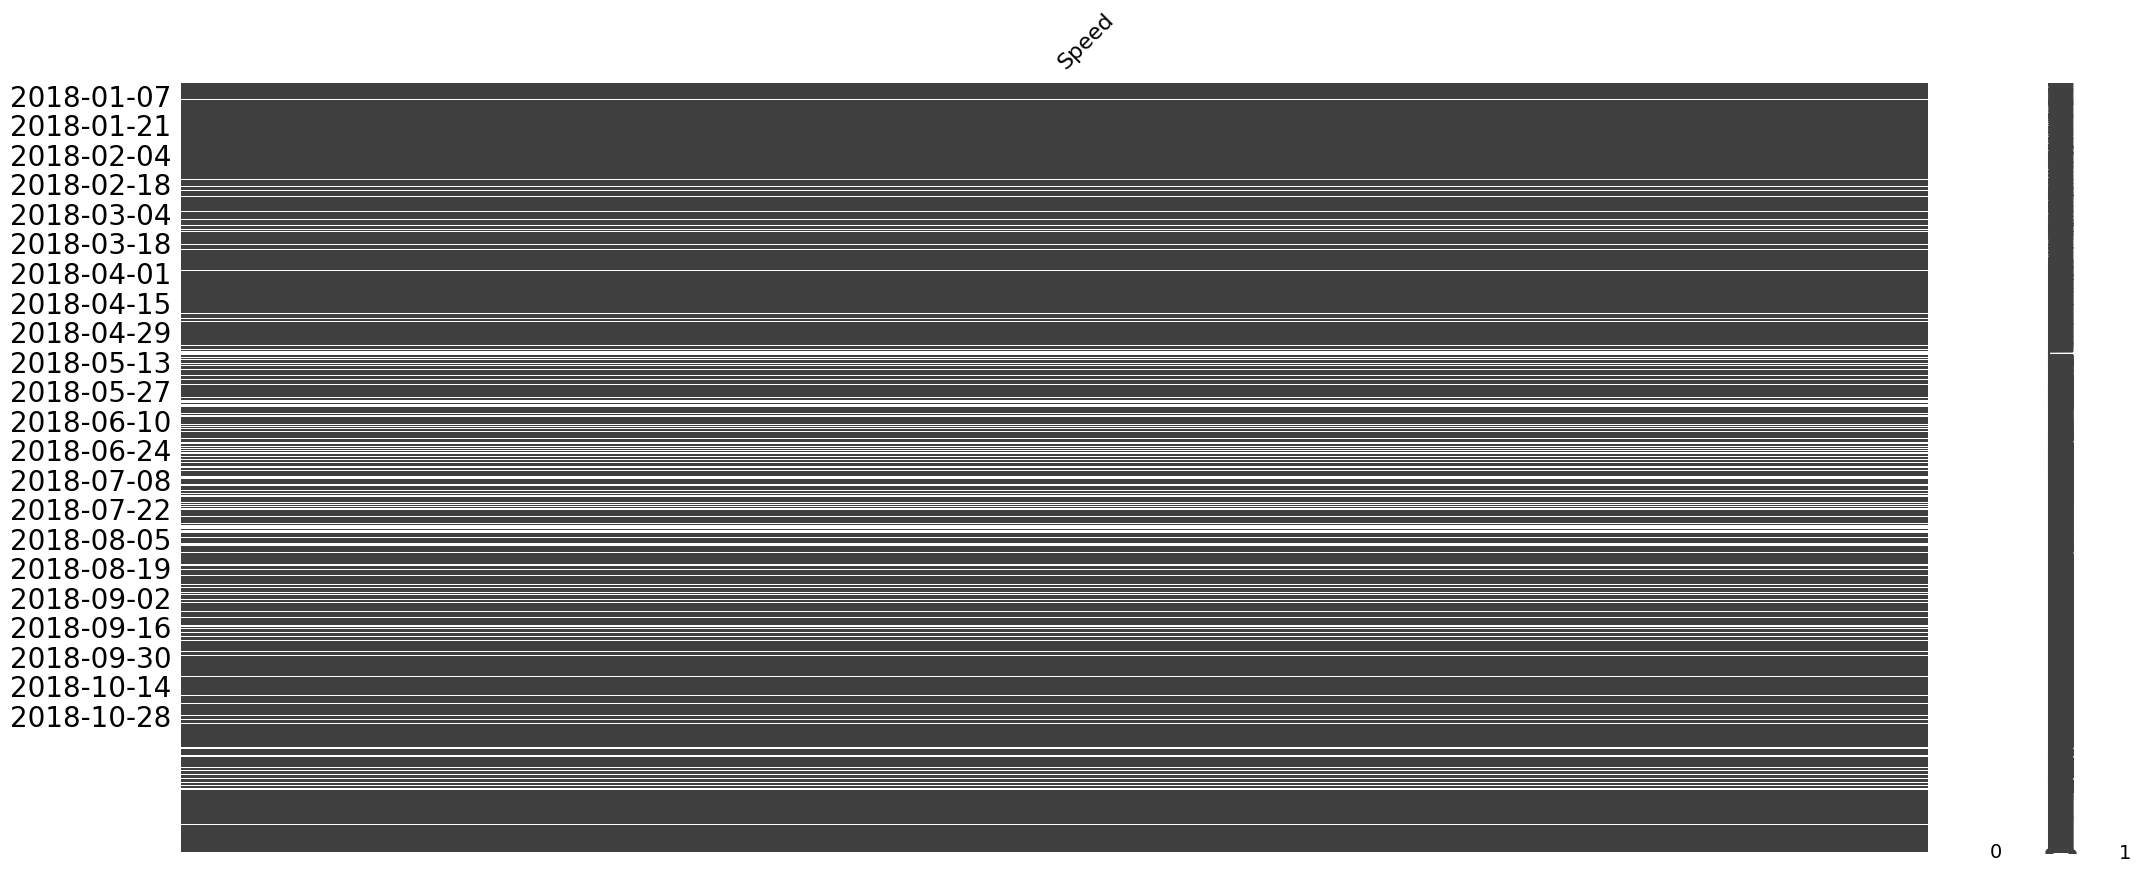

In [148]:

df = pd.read_csv('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018/72.2.28_processed.csv', parse_dates=['DateTimeStamp'], index_col='DateTimeStamp')
df.drop(df.columns[[0, 1]], axis=1, inplace=True)
# Visualize missing values using missingno
msno.matrix(df, freq='2W')
